# Deep Learning
### 視程カテゴリーを予測する

#### データの前処理

In [1]:
import numpy as np
import pandas as pd
np.random.seed(443)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## 学習用データ
DATA = pd.read_csv("train_data.csv")

# 使うデータを限定
use_valiable = ["DateTime","VIS","VIS_CAT","FG","PRCP_P24HR",\
                "RH_SFC","TMP_SFC","TD_SFC","PRES_SFC","LCDC_SFC","MCDC_SFC","HCDC_SFC",\
                "WSPD_SFC","WDIR_SFC","APCP_SFC","TimeRange","MONTH","D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
                "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA",\
                "RH_1000","VVEL_1000","WSPD_1000","RH_975","VVEL_975","WSPD_975",\
                "RH_950","VVEL_950","WSPD_950","RH_850","RH_700","RH_500","RH_300"]
DATA = DATA[use_valiable]

# カテゴリー変数はダミー化
cat_val = ['WDIR_SFC', 'TimeRange', 'MONTH']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

# 雨が降った後の夜間に霧が出やすいことを表現できるかもしれない
DATA["Time_12-14_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_12-14"]
DATA["Time_15-17_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_15-17"]
DATA["Time_18-20_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_18-20"]
DATA["Time_21-23_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_21-23"]

# 不均衡データ対応
# VIS 5000m以上を減らし、VIS 5000m未満を増やす
def Sampling_Flag(data):
    flag = np.full( data.shape[0], 0 )
    flag[ data > 0 ] = 1
    return flag

DATA["FLAG"] = Sampling_Flag( DATA.VIS_CAT )

target = 'FLAG'
exclude = ['FLAG','DateTime']
features = [val for val in DATA.columns if val not in exclude]

y = np.array( DATA[target] )
X = np.array( DATA[features] )

# count = int( y[y==0].shape[0]/2 )
# rus = RandomUnderSampler(ratio={0:count}, random_state=443)
# X_rus, y_rus = rus.fit_sample(X,y)

# count = y_rus[y_rus==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X_rus,y_rus)

# count = y[y==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X,y)

# DATA = pd.DataFrame( X_sm, columns=features )
DATA = pd.DataFrame( X, columns=features )
DATA.FG = DATA.FG.astype(np.int64)
DATA.VIS_CAT = DATA.VIS_CAT.astype(np.int64)

In [3]:
## 予測テスト用データ
TEST = pd.read_csv("test_data.csv")
TEST = TEST[use_valiable].drop("DateTime", axis=1)
TEST = pd.get_dummies(data=TEST, columns=cat_val)

TEST["Time_12-14_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_12-14"]
TEST["Time_15-17_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_15-17"]
TEST["Time_18-20_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_18-20"]
TEST["Time_21-23_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_21-23"]

### Chainerを使う

In [4]:
from chainer import Chain, Variable, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam, MomentumSGD, RMSprop
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater
from chainer.training import Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import spearmanr
from pylab import rcParams
import re

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
target = 'VIS_CAT'
exclude = ['VIS','VIS_CAT','FG','PRCP_P24HR']
features = [val for val in DATA.columns if val not in exclude]

# 特徴量を割り算で作成
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(features)-1):
    for j in range(i+1, len(features)):
        first_col_name = features[i]
        second_col_name = features[j]
        r = spearmanr(DATA[first_col_name], DATA[second_col_name]).correlation        
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            DATA[new_colname] = DATA[first_col_name] / (DATA[second_col_name] + 0.001)
            new_added_col.append(new_colname)
features = features + new_added_col

# 増えた特徴量をテストデータでも作成
for feature in features:
    if re.search('_div_', feature):
        feature1, feature2 = feature.split("_div_")
        TEST[feature] = TEST[feature1] / (TEST[feature2] + 0.001)

X = DATA[features]
Y = DATA[target]
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

X_test = TEST[features]
Y_test = TEST[target]

In [6]:
## Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_dev = scaler.transform( X_dev )
X_test = scaler.transform( X_test )

## Chainer用の変換
Y_train = Y_train.values
Y_dev = Y_dev.values
Y_test = Y_test.values

X_train = X_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)
X_test = X_test.astype(np.float32)

Y_train = Y_train.astype(np.int32)
Y_dev = Y_dev.astype(np.int32)
Y_test = Y_test.astype(np.int32)

In [7]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(500)
            self.l2 = L.Linear(1000)
            self.l3 = L.Linear(500)
            self.l4 = L.Linear(5)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l3(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l4(h)
        return h

In [8]:
# 保存したモデルを呼び出す
from chainer import serializers
model = Model()
serializers.load_npz("DNN_CLF_lr1.npz", model)

#### Permutation Importance

In [12]:
from eli5.permutation_importance import get_score_importances

def score_ETS(X, y):
    rank = 3
    obs_cat = y
    
    with configuration.using_config('train', False):
        y_pred = model(X)
    fcst_cat = np.argmax(y_pred.data, axis=1)

    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    Pc = len(obs_onoff[ obs_onoff == 1 ]) / len(obs_onoff)
    Sf = Pc * ( m[1,1] + m[0,1] ) # ランダム的中率
    ets = ( m[1,1] - Sf ) / ( m[0,1] + m[1,0] + m[1,1] - Sf )
    return ets

base_score, score_decreases = get_score_importances(score_ETS, X_test, Y_test, n_iter=10)
feature_importances = np.mean(score_decreases, axis=0)
importances_stdev = np.std(score_decreases, axis=0)

In [15]:
per_imp = pd.DataFrame({"Mean" : feature_importances, "Std. Dev" : importances_stdev}, index=features)
per_imp = per_imp.sort_values('Mean', ascending=False)
per_imp.head(10)

,Mean,Std. Dev
LL_STBL1,0.069564,0.015388
RH_SFC,0.051147,0.012137
RH_1000,0.047922,0.012730
RH_975,0.031493,0.015203
RH_1000_div_RH_975,0.030476,0.009868
RH_950,0.028767,0.016977
LL_STBL2,0.023026,0.015189
WSPD_1000,0.019791,0.008799
MCDC_SFC_div_APCP_SFC,0.019638,0.009203
TD_SFC_div_PRES_SFC,0.019335,0.009069


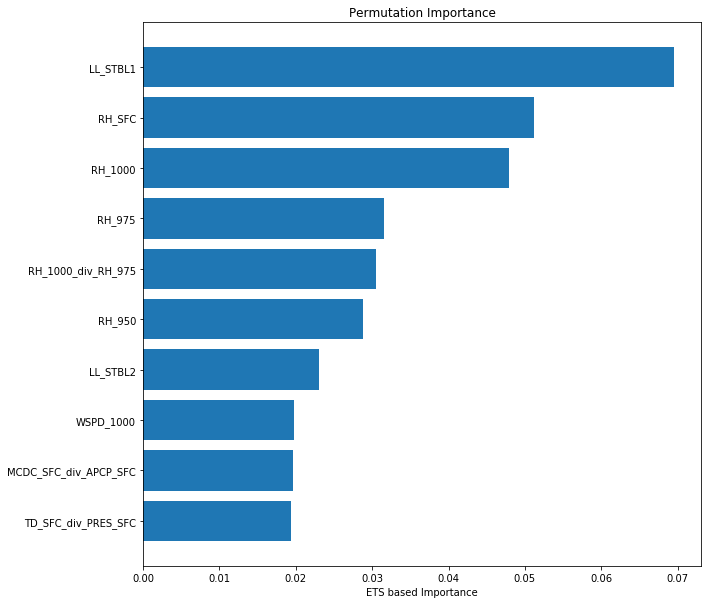

In [20]:
from matplotlib import pyplot as plt
% matplotlib inline

rcParams['figure.figsize'] = 10,10
pos = np.arange(10) + .5
plt.barh(pos, per_imp.Mean[9::-1], align='center')
plt.yticks(pos, per_imp.index[9::-1])
plt.xlabel('ETS based Importance')
plt.title('Permutation Importance')
plt.show()

#### Partial Dependence Plot

In [21]:
### 霧予測（or 視程カテゴリー）をリターンするクラス
# PDPboxでは、predictメソッドのあるモデルしか受け付けないため、自分で作成
class FG_forecast:
    def __init__(self,model,rank):
        self.model = model
        self.rank = rank
        
    def predict(self,X):
        with configuration.using_config('train', False):
            X_input = np.array(X)
            y_pred = self.model( X_input.astype(np.float32) )
        fcst_cat = np.argmax(y_pred.data, axis=1)
        # カテゴリー予測をリターンする場合
        # return fcst_cat
        
        # 霧の有無予測をリターンする場合
        fcst_onoff = np.full( len(fcst_cat), 0 )
        fcst_onoff[ fcst_cat >= self.rank ] = 1
        return fcst_onoff

In [45]:
from pdpbox import pdp, get_dataset, info_plots

# モデルのインスタンス
fg = FG_forecast(model,rank=3)

# Create the data that we will plot
df = pd.DataFrame( X_test, columns=features )
# df = pd.DataFrame( X_test[Y_test==1], columns=features )

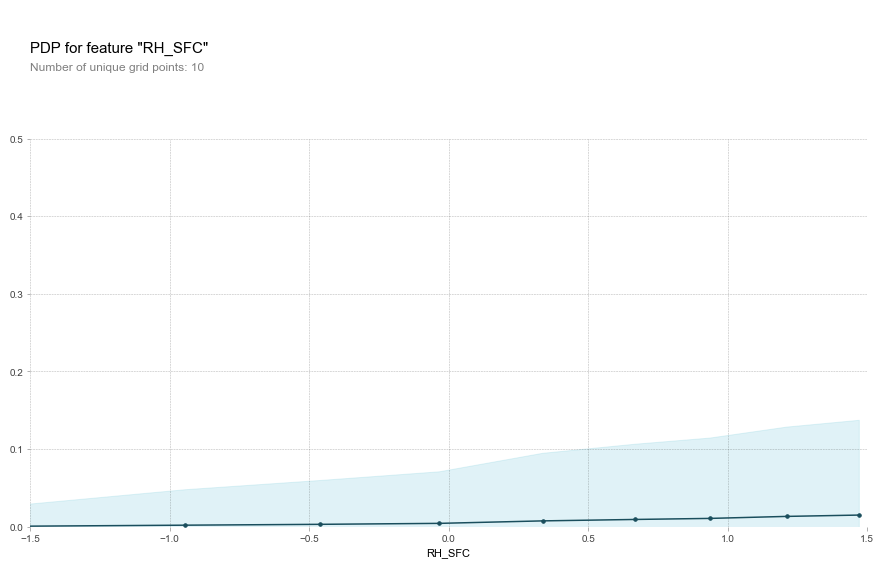

In [62]:
pdp1 = pdp.pdp_isolate(model=fg, dataset=df, model_features=features, feature='RH_SFC', n_jobs=-1)
fig, axes = pdp.pdp_plot(pdp1, 'RH_SFC')
plt.xlim([-1.5, 1.5])
plt.ylim([0, 0.5])
plt.show()

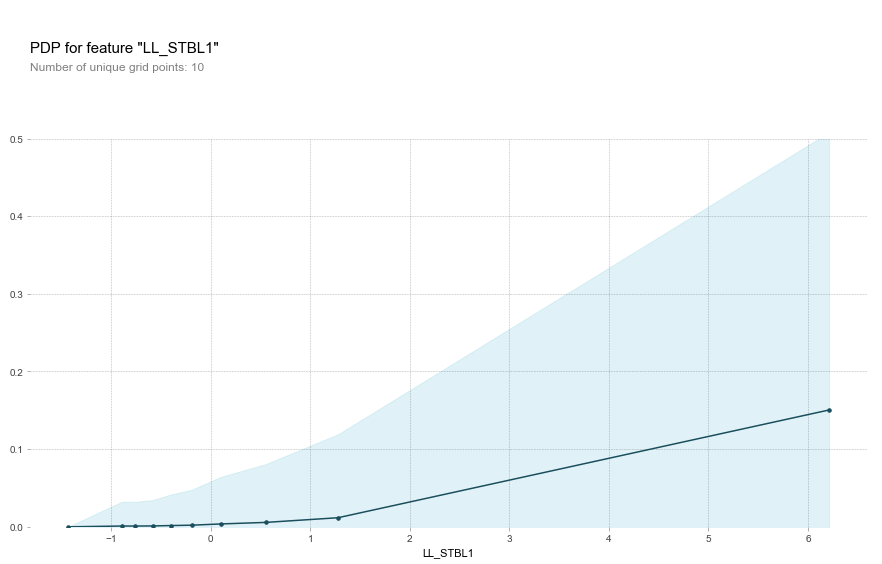

In [59]:
pdp2 = pdp.pdp_isolate(model=fg, dataset=df, model_features=features, feature='LL_STBL1', n_jobs=-1)
fig, axes = pdp.pdp_plot(pdp2, 'LL_STBL1')
# plt.xlim([0, 1.5])
plt.ylim([0, 0.5])
plt.show()

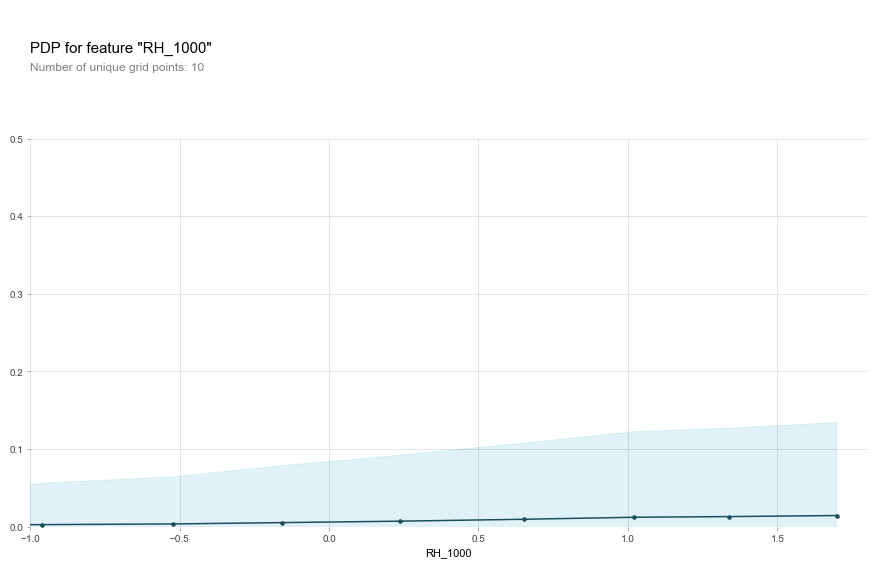

In [63]:
pdp3 = pdp.pdp_isolate(model=fg, dataset=df, model_features=features, feature='RH_1000', n_jobs=-1)
fig, axes = pdp.pdp_plot(pdp3, 'RH_1000')
plt.xlim([-1.0, 1.8])
plt.ylim([0, 0.5])
plt.show()

In [58]:
# スケールの確認
tmp = X_test * 1.0

# RH_SFC
tmp[0,0] = -1.0
tmp[1,0] = 0.0
tmp[2,0] = 0.5
tmp[3,0] = 1.0
tmp[4,0] = 1.5

# LL_STBL1
tmp[0,14] = -1.0
tmp[1,14] = 0
tmp[2,14] = 1
tmp[3,14] = 2
tmp[4,14] = 3
tmp[5,14] = 4
tmp[6,14] = 5
tmp[7,14] = 6

# RH_1000
tmp[0,17] = -1.0
tmp[1,17] = 0.0
tmp[2,17] = 0.5
tmp[3,17] = 1.0
tmp[4,17] = 1.5

inv_data = scaler.inverse_transform( tmp )

print("RH_SFC : {}".format(inv_data[0:5,0]))
print("LL_STBL1 : {}".format(inv_data[0:8,14]))
print("RH_1000 : {}".format(inv_data[0:5,17]))

RH_SFC : [ 53.03431  71.96749  81.43408  90.90067 100.36726]
LL_STBL1 : [-1.0327268  -0.5755218  -0.11831696  0.33888793  0.79609287  1.2532977
  1.7105025   2.1677074 ]
RH_1000 : [47.92783  67.068054 76.63816  86.208275 95.77839 ]


#### SHAP Value

In [66]:
# スケーリングされているデータを、データフレームに戻す
df_X_train = pd.DataFrame( X_train, columns=features )
df_X_test = pd.DataFrame( X_test, columns=features )

# row = 5
# select_data = X_test[row].reshape(1, -1)

In [74]:
# 霧の有無の予測値を取得
with configuration.using_config('train', False):
    y_calc = model(X_test)
fg_pred = np.argmax(y_calc.data, axis=1)

# テストデータを読み直す
test_data = pd.read_csv("test_data.csv")
test_data["FG_fcst"] = fg_pred
test_data = test_data[["DateTime","VIS","VIS_CAT","FG","RH_SFC","LL_STBL1","RH_1000","FG_fcst"]]

In [75]:
# 霧の事例を抽出
test_data[ test_data.VIS_CAT==4 ]

,DateTime,VIS,VIS_CAT,FG,RH_SFC,LL_STBL1,RH_1000,FG_fcst
1315,2017/03/02 17:00:00,600,4,1,97.40,0.062799,98.11,0
1316,2017/03/02 18:00:00,100,4,1,99.42,0.367363,99.36,0
1317,2017/03/02 19:00:00,200,4,1,99.38,0.705007,94.69,4
1318,2017/03/02 20:00:00,200,4,1,96.54,1.042018,90.03,4
1319,2017/03/02 21:00:00,700,4,1,92.50,1.378313,85.36,4
2064,2017/04/08 16:00:00,700,4,1,93.44,-0.670613,92.55,0
2523,2017/04/28 16:00:00,700,4,1,93.33,1.154063,83.39,0
2685,2017/05/05 17:00:00,500,4,1,99.14,0.718191,96.83,0
2686,2017/05/05 18:00:00,500,4,1,99.31,0.482733,97.63,0
2687,2017/05/05 19:00:00,600,4,1,99.15,0.506388,98.18,0


事例をピックアップ  
1319 03/02 21:00 湿度はほどほどだが安定度高く、霧と予想している（VIS_OBS=700, FCST_CAT=4）  
2523 04/28 16:00 上とほぼ同条件ながら、霧と予想していない（VIS_OBS=700, FCST_CAT=0）  
5239 08/25 19:00 湿度・安定度とも条件よく、霧と予想できている（VIS_OBS=500, FCST_CAT=4）  
6251 10/08 21:00 湿度は高いが、安定度が悪く、霧と予想していない（VIS_OBS=500, FCST_CAT=0）  
7536 12/04 21:00 湿度は90％未満だが安定度が高い、霧の予想はできている（VIS_OBS=100, FCST_CAT=3）  

In [80]:
test_data.iloc[[1319,2523,5239,6251,7536]]

,DateTime,VIS,VIS_CAT,FG,RH_SFC,LL_STBL1,RH_1000,FG_fcst
1319,2017/03/02 21:00:00,700,4,1,92.50,1.378313,85.36,4
2523,2017/04/28 16:00:00,700,4,1,93.33,1.154063,83.39,0
5239,2017/08/25 19:00:00,500,4,1,98.45,1.114181,97.09,4
6251,2017/10/08 21:00:00,500,4,1,99.05,-0.553000,92.65,0
7536,2017/12/04 21:00:00,100,4,1,87.70,1.426924,85.34,3


In [85]:
import shap  # package used to calculate Shap values

# ピックアップした事例
data_for_prediction = df_X_test.iloc[[1319,2523,5239,6251,7536]]

# SHAP value
# データ量が多いので、まずkmeansでクラスタリングしている
shap.initjs()
background = shap.kmeans(df_X_train, 100)
explainer = shap.KernelExplainer(fg.predict, background)
shap_value = explainer.shap_values(data_for_prediction)


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


In [89]:
shap_value.shape

(5, 124)

In [91]:
# 1319 03/02 21:00 湿度はほどほどだが安定度高く、霧と予想している（VIS_OBS=700, FCST_CAT=4）
shap.force_plot(explainer.expected_value, shap_value[0], data_for_prediction.iloc[0])

In [104]:
chk_shap1 = pd.DataFrame({"SHAP" : shap_value[0]}, index=features)
chk_shap1.sort_values('SHAP', ascending=False)

,SHAP
LL_STBL1,0.317729
RH_1000_div_RH_975,0.164853
RH_SFC,0.103021
D_TD_SFC,0.102185
Time_21-23_RAp24hr,0.077804
RH_SFC_div_RH_975,0.067013
RH_1000,0.056737
HCDC_SFC,0.056542
RH_1000_div_RH_950,0.043916
WSPD_1000,0.033352


In [92]:
# 2523 04/28 16:00 上とほぼ同条件ながら、霧と予想していない（VIS_OBS=700, FCST_CAT=0）
shap.force_plot(explainer.expected_value, shap_value[1], data_for_prediction.iloc[1])

In [103]:
chk_shap2 = pd.DataFrame({"SHAP" : shap_value[1]}, index=features)
chk_shap2.sort_values('SHAP', ascending=False)

,SHAP
LL_STBL1,0.104527
RH_1000_div_RH_975,0.048379
RH_SFC_div_RH_975,0.034057
RH_500,0.031354
RH_SFC,0.030271
LL_STBL2,0.026041
WDIR_SFC_N,0.016167
TMP_SFC,0.015494
LL_VWS2_div_LL_STBL1,0.014447
LL_VWS2,0.014315


In [93]:
# 5239 08/25 19:00 湿度・安定度とも条件よく、霧と予想できている（VIS_OBS=500, FCST_CAT=4）
shap.force_plot(explainer.expected_value, shap_value[2], data_for_prediction.iloc[2])

In [102]:
chk_shap3 = pd.DataFrame({"SHAP" : shap_value[2]}, index=features)
chk_shap3.sort_values('SHAP', ascending=False)

,SHAP
LL_STBL1,0.299131
RH_SFC,0.143325
RH_1000,0.129113
WSPD_1000,0.062167
TD_SFC,0.059598
TimeRange_18-20_div_Time_18-20_RAp24hr,0.055245
LL_STBL2,0.053098
RH_1000_div_RH_950,0.049656
RH_1000_div_RH_975,0.045793
VVEL_950,0.041844


In [94]:
# 6251 10/08 21:00 湿度は高いが、安定度が悪く、霧と予想していない（VIS_OBS=500, FCST_CAT=0）
shap.force_plot(explainer.expected_value, shap_value[3], data_for_prediction.iloc[3])

In [99]:
chk_shap4 = pd.DataFrame({"SHAP" : shap_value[3]}, index=features)
chk_shap4.sort_values('SHAP', ascending=False)

,SHAP
LCDC_SFC_div_RH_850,0.022254
LL_STBL2,0.015664
LCDC_SFC,0.008754
HCDC_SFC,0.008749
D_TMP_SFC,0.005532
MCDC_SFC_div_RH_950,0.005404
RH_975_div_RH_700,0.005168
MCDC_SFC_div_RH_700,0.005068
APCP_SFC_div_RH_950,0.004775
MONTH_6,0.004657


In [100]:
# 7536 12/04 21:00 湿度は90％未満だが安定度が高い、霧の予想はできている（VIS_OBS=100, FCST_CAT=3）
shap.force_plot(explainer.expected_value, shap_value[4], data_for_prediction.iloc[4])

In [101]:
chk_shap5 = pd.DataFrame({"SHAP" : shap_value[4]}, index=features)
chk_shap5.sort_values('SHAP', ascending=False)

,SHAP
LL_STBL1,0.297722
D_TD_SFC,0.173780
LL_STBL2,0.161103
Time_21-23_RAp24hr,0.113129
RH_1000,0.093959
WSPD_950,0.070807
RH_SFC,0.063690
LL_STBL2_div_RH_1000,0.055133
RH_1000_div_RH_950,0.047761
TMP_SFC_div_PRES_SFC,0.045725
